In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from annoy import AnnoyIndex
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [4]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [5]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
                                       

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0241 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.008

In [8]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

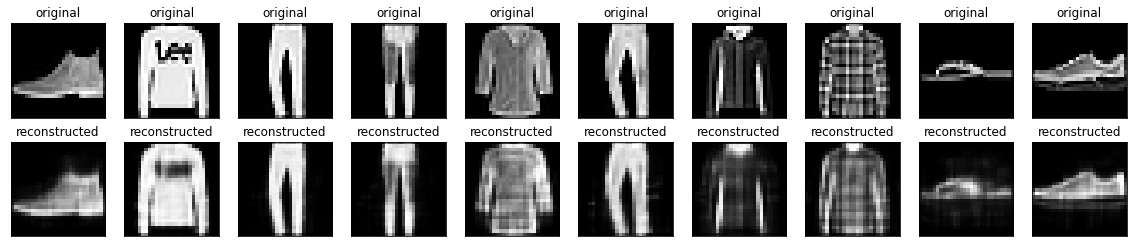

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
res1 = autoencoder.encoder(x_test[:1]).numpy()

In [11]:
# Querying images

encoding_vector_length = 64
annoy_file_name = 'fashion-mnist.annoy.index'
num_trees = 10


In [12]:
def build_annoy_index(encoding_dim, num_trees, annoy_index_file, encodings):   
    ann = AnnoyIndex(encoding_dim, metric='angular')   
    for index, encoding in enumerate(encodings):
        ann.add_item(index, encoding)
    ann.build(num_trees)
    ann.save(annoy_index_file)
    print("Created Annoy Index Successfully")

build_annoy_index(encoding_vector_length, num_trees, annoy_file_name, encoded_imgs)

Created Annoy Index Successfully


C:\Users\User\AppData\Local\Temp\ipykernel_3344\2485409133.py:1: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  saved_ann = AnnoyIndex(encoding_vector_length)


Original image


'Shirt'

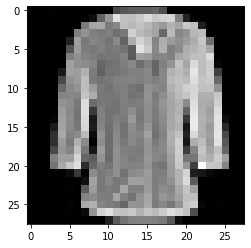

In [31]:
saved_ann = AnnoyIndex(encoding_vector_length)
saved_ann.load(annoy_file_name)

search_img_id = 4

nn_indices = saved_ann.get_nns_by_vector(encoded_imgs[search_img_id], 10)
print("Original image")
plt.imshow(x_test[search_img_id], cmap='Greys_r')
labeldict[y_test[search_img_id]]

Similar images are


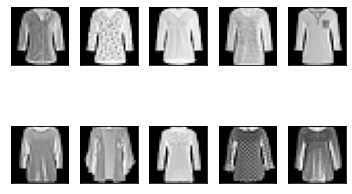

In [32]:
print("Similar images are")
for i, index in enumerate(nn_indices,1):
    image = x_test[index].reshape(28,28)
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap='Greys_r')